In [11]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

SAVE_PATH = r"E:\MS_ExperimentData\general"
MP4_PATH = r"E:\MS_ExperimentData\mp4"
LOCAL_FIG_PATH = "./PCT_C_figs"
PCT_C_PATH = r"F:\c-doc\PJT_phaseLag_enhance_phase_seperation\figs"

In [2]:
omegaMins = np.linspace(0.1, 3, 21)
phaseLags = np.linspace(-1, 1, 21) * np.pi
randomSeed = 10
strengthLambda = 0.15 * 32 * 2
distanceD0 = 1
deltaOmega = 1
boundaryLength = 7
agnetsCount = 1000
halfAgentsNum = agnetsCount // 2
Homega = np.block([
    [np.ones((halfAgentsNum, halfAgentsNum)), np.zeros((halfAgentsNum, halfAgentsNum))],
    [np.zeros((halfAgentsNum, halfAgentsNum)), np.ones((halfAgentsNum, halfAgentsNum))]
])

---
# Load Last State

In [3]:
lastStatePath = (
    f"./last_state/MeanFieldChiralInducedPhaseLag_lastState"
    f"_l{strengthLambda}_d{distanceD0}_dO{deltaOmega}_rS{randomSeed}.h5"
)

totalPositionX = pd.read_hdf(lastStatePath, key="positionX")
totalPhaseTheta = pd.read_hdf(lastStatePath, key="phaseTheta")
totalDotTheta = pd.read_hdf(lastStatePath, key="pointTheta")

modelNums = totalPositionX.shape[0] // (halfAgentsNum * 2)

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalDotTheta = totalDotTheta.values.reshape(modelNums, agnetsCount)

positionXs, phaseThetas, dotThetas = {}, {}, {}

for idx, (omegaMin, phaseLag) in enumerate(product(omegaMins.round(2), phaseLags.round(2))):
    positionXs[(omegaMin, phaseLag)] = totalPositionX[idx]
    phaseThetas[(omegaMin, phaseLag)] = totalPhaseTheta[idx]
    dotThetas[(omegaMin, phaseLag)] = totalDotTheta[idx]

---
# Snapshot

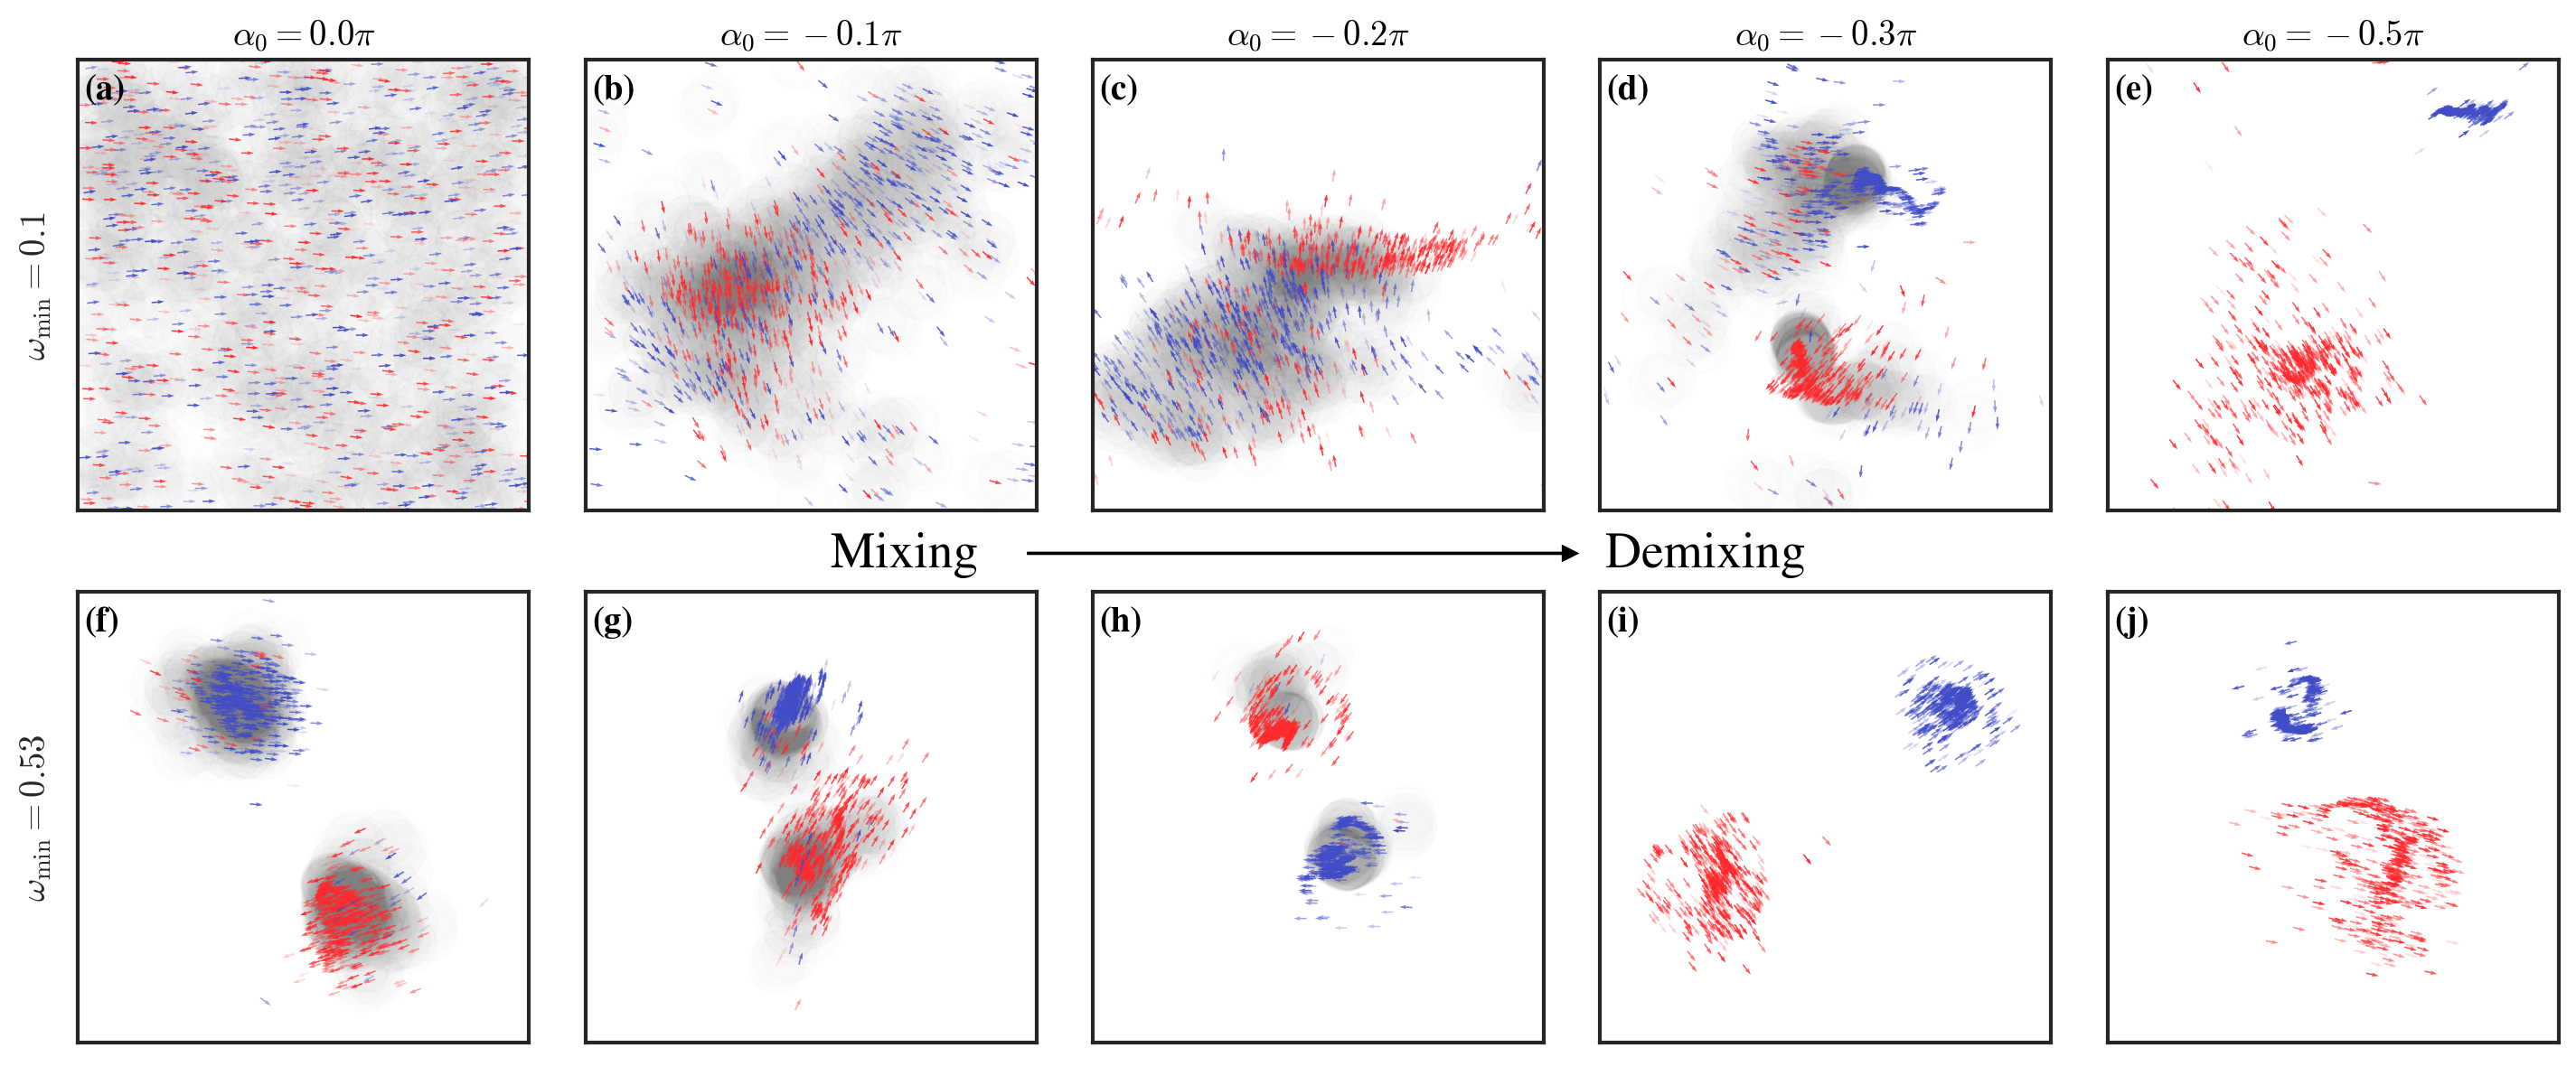

In [81]:
selectedOmegaMins = [0.1, 0.53]
selectedPhaseLags = (np.array([0, -0.1, -0.2, -0.3, -0.5]) * np.pi).round(2)
shiftXs = [0,  0, 3, 3, 3,    2,   -1,  0, -0.5,    0]
shiftYs = [0, -2, 1, 2, 0, -0.5, -1.5, -2, -0.5, -0.5]

fig, axs = plt.subplots(2, 5, figsize=(14.5, 6))
axs = axs.flatten()

for idx, (omegaMin, phaseLag) in enumerate(product(selectedOmegaMins, selectedPhaseLags)):
    positionX = positionXs[(omegaMin, phaseLag)].copy()
    phaseTheta = phaseThetas[(omegaMin, phaseLag)]

    positionX[:, 0] = np.mod(positionX[:, 0] + shiftXs[idx], boundaryLength)
    positionX[:, 1] = np.mod(positionX[:, 1] + shiftYs[idx], boundaryLength)
    omegaMax = omegaMin + deltaOmega
    omegaTheta = np.concatenate([
        np.random.uniform(omegaMin, omegaMax, size=500),
        np.random.uniform(-omegaMax, -omegaMin, size=500)
    ])
    deltaX = MeanFieldChiralInducedPhaseLag._delta_x(
        positionX, positionX[:, np.newaxis], boundaryLength, boundaryLength / 2
    )
    Aij = MeanFieldChiralInducedPhaseLag.distance_x(deltaX) <= 0.3
    hasAround = np.sign(((1 - Homega) * Aij).sum(axis=0))

    ax = axs[idx]
    ax.scatter(
        positionX[:, 0], positionX[:, 1], alpha=0.01, zorder=0, s=500,
        color=list(map(lambda x: "gray" if x == 1 else "#FFFFFF", hasAround)),
    )
    scale = 35
    width = 0.003
    alphaRate = 0.9
    ax.quiver(
        positionX[:halfAgentsNum, 0], positionX[:halfAgentsNum, 1],
        np.cos(phaseTheta[:halfAgentsNum]), np.sin(phaseTheta[:halfAgentsNum]), color="#FF2A2E", 
        alpha = (1 - alphaRate) + (np.abs(omegaTheta[:halfAgentsNum]) - omegaMin) / deltaOmega * alphaRate,
        scale=scale, width=width
    )
    ax.quiver(
        positionX[halfAgentsNum:, 0], positionX[halfAgentsNum:, 1],
        np.cos(phaseTheta[halfAgentsNum:]), np.sin(phaseTheta[halfAgentsNum:]), color="#414CC7",
        alpha = (1 - alphaRate) + (np.abs(omegaTheta[:halfAgentsNum]) - omegaMin) / deltaOmega * alphaRate,
        scale=scale, width=width
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    ax.set_xlim(0, boundaryLength)
    ax.set_ylim(0, boundaryLength)
    if idx % 5 == 0:
        ax.set_ylabel(rf"$\omega_{{\min}}={omegaMin}$", fontsize=14)
    if idx < 5:
        ax.set_title(rf"$\alpha_0={phaseLag / np.pi:.1f}\pi$", fontsize=14)
    ax.text(0.1, 6.4, f"({chr(97 + idx)})", fontsize=14, fontweight="bold")
    ax.set_aspect("equal")

axs[7].set_title(rf"Mixing{' ' * 50}Demixing", fontsize=20, pad=10)

plt.tight_layout()
axs[7].arrow(-1, 7.6, 8.3, 0, head_width=0.2, head_length=0.2, lw=1.2, fc="black", ec="black", clip_on=False)

plt.savefig(f"{PCT_C_PATH}/snapshots.pdf", bbox_inches="tight")

---
# Center Scatter

In [40]:
model1 = MeanFieldChiralInducedPhaseLag(
    strengthLambda=9.6, distanceD0=1, boundaryLength=7,
    phaseLag=0, 
    distribution="uniform", initPhaseTheta=np.zeros(1000),
    omegaMin=0.68, deltaOmega=1,
    agentsNum=1000, savePath=SAVE_PATH, dt=0.01,
    tqdm=True, overWrite=True, randomSeed=9, shotsnaps=10
)
sa1 = StateAnalysis(model1)

model2 = MeanFieldChiralInducedPhaseLag(
    strengthLambda=9.6, distanceD0=1, boundaryLength=7,
    phaseLag=-0.3 * np.pi, 
    distribution="uniform", initPhaseTheta=np.zeros(1000),
    omegaMin=0.68, deltaOmega=1,
    agentsNum=1000, savePath=SAVE_PATH, dt=0.01,
    tqdm=True, overWrite=True, randomSeed=9, shotsnaps=10
)
sa2 = StateAnalysis(model2)

length = sa1.totalPhaseTheta.shape[0]
rawClass1, rawClass2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
tRanges = np.arange(length).repeat(1000)
class1 = np.concatenate([rawClass1] * length)
class2 = np.concatenate([rawClass2] * length)

tsCentersList = []
totalCentersList = []

for sa in [sa1, sa2]:

    model = sa.model
    tsCenters = []

    for i in tqdm(range(1, length, 1)):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        omegaTheta = model.omegaTheta

        center = np.array([
            positionx - model.speedV * model.dt / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + model.speedV * model.dt / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T

        tsCenters.append(center)

    tsCenters.insert(0, tsCenters[0])
    totalCenters = np.array(tsCenters)
    tsCenters = np.concatenate(tsCenters)
    tsCenters = np.mod(tsCenters, model.boundaryLength)
    totalCenters = np.mod(totalCenters, model.boundaryLength)

    tsCentersList.append(tsCenters)
    totalCentersList.append(totalCenters)

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

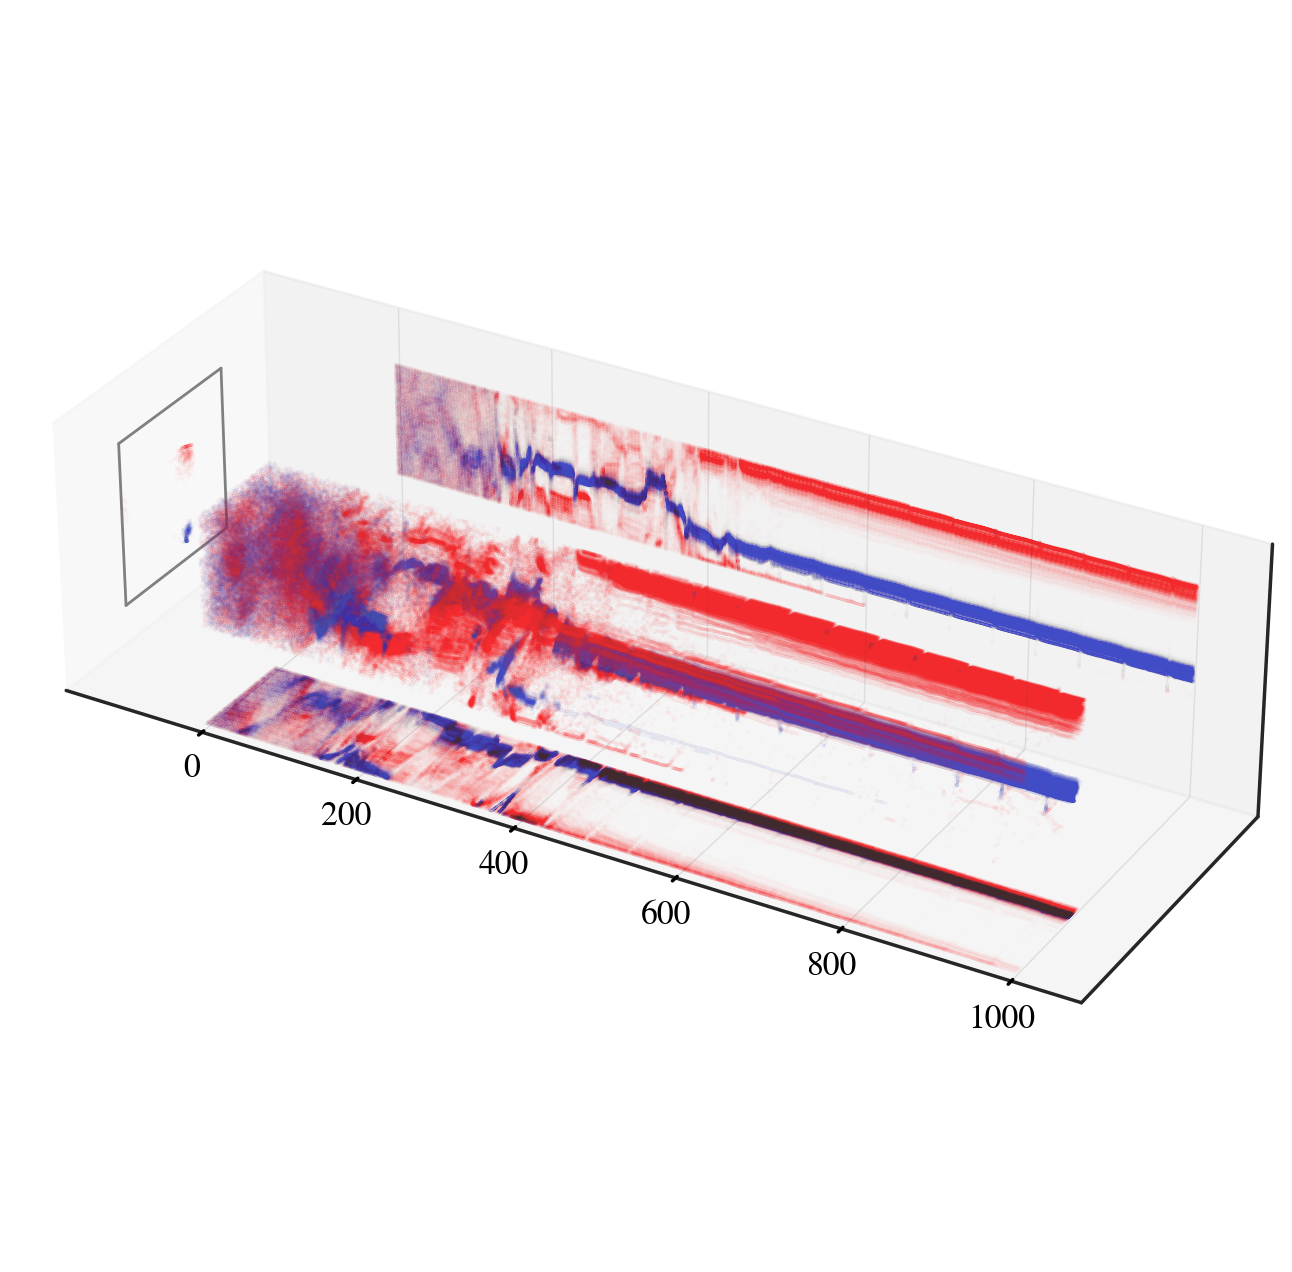

In [41]:
color = ["#FF2A2E"] * 500 + ["#414CC7"] * 500
colors = np.array(color * (tRanges.shape[0] // 1000))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
lowLim = -6
backLim = 20
alpha1 = 0.1
alpha2 = 0.01
s = 0.01

ax.scatter(tRanges, tsCenters[:, 0], tsCenters[:, 1], s=s, alpha=alpha1, c=colors)

bottom = -100

# F16623, 49B2B2
ax.scatter(bottom, totalCenters[-1, rawClass1, 0], totalCenters[-1, rawClass1, 1], s=s, alpha=alpha1, color="#FF2A2E")
ax.scatter(bottom, totalCenters[-1, rawClass2, 0], totalCenters[-1, rawClass2, 1], s=s, alpha=alpha1, color="#414CC7")
ax.plot3D([bottom, bottom], [0, 0], [10, 0], 'gray', lw=1)
ax.plot3D([bottom, bottom], [10, 10], [10, 0], 'gray', lw=1)
ax.plot3D([bottom, bottom], [0, 10], [0, 0], 'gray', lw=1)
ax.plot3D([bottom, bottom], [0, 10], [10, 10], 'gray', lw=1)

ax.scatter(tRanges, tsCenters[:, 0], np.ones_like(tsCenters[:, 1]) * lowLim, s=s, alpha=alpha2, c=colors)

ax.scatter(tRanges, np.ones_like(tsCenters[:, 0]) * backLim, tsCenters[:, 1], s=s, alpha=alpha2, c=colors)

ax.set_ylim(0, backLim)
ax.set_zlim(lowLim, 10)
ax.set_box_aspect([3, 1, 1 / backLim * (10 - lowLim)])
ax.set_yticks([], [])
ax.set_zticks([], [])
ax.set_xticks(ax.get_xticks()[1:-1])

plt.savefig(f"{LOCAL_FIG_PATH}/centersScatter.png", dpi=300, bbox_inches="tight")

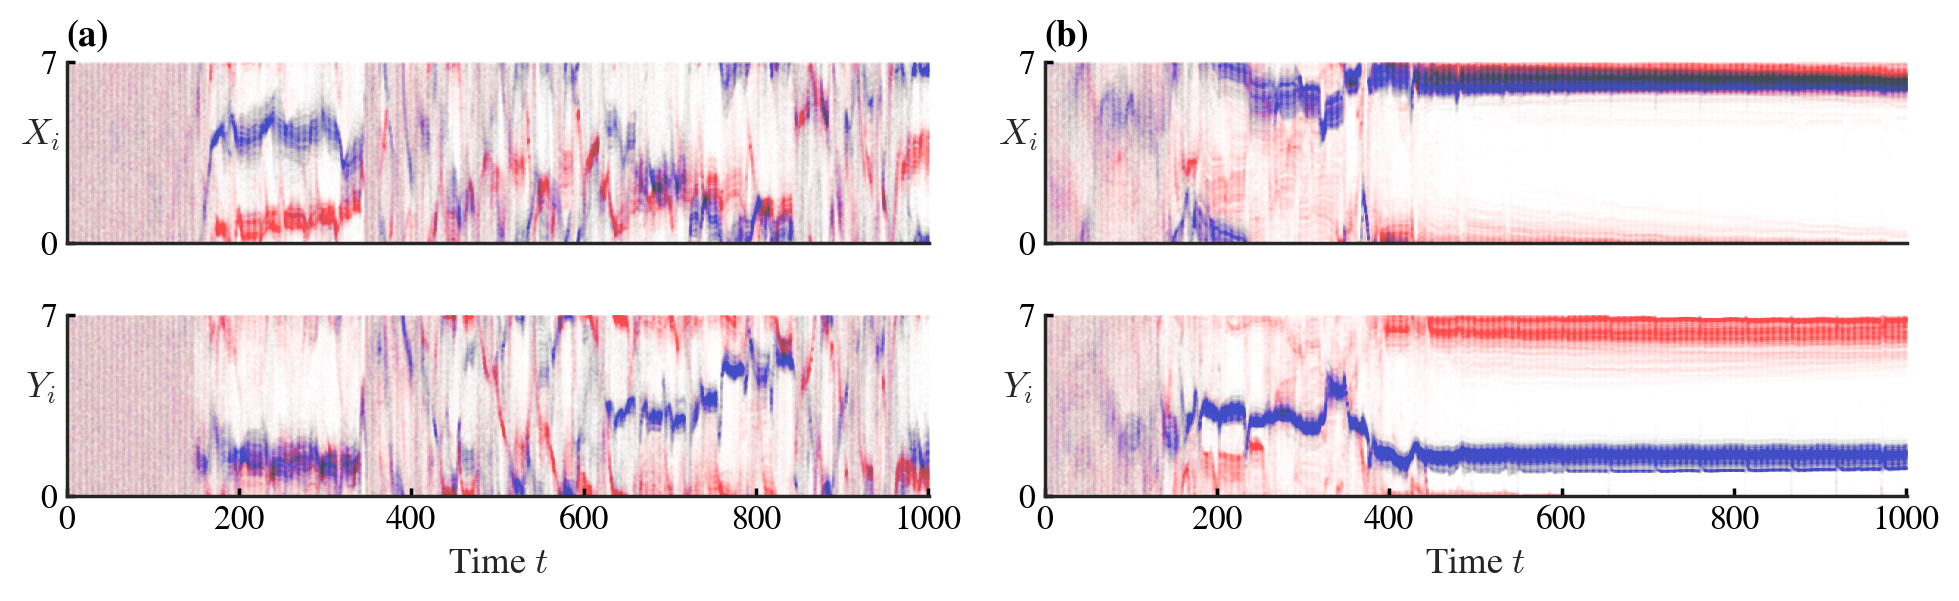

In [79]:
class1Color = "#FF4B4E"
class2Color = "#414CC7"

s = 0.2
alpha = 0.004

fig, axs = plt.subplots(2, 2, figsize=(10, 3.2))
ax = plt.subplot(221)
plt.scatter(tRanges[class1], tsCentersList[0][class1, 0], s=s, alpha=alpha, color=class1Color)
plt.scatter(tRanges[class2], tsCentersList[0][class2, 0], s=s, alpha=alpha, color=class2Color)
plt.xticks([])
plt.ylabel(r"$X_i$", rotation=0, labelpad=0)
plt.title("(a)", loc="left", fontweight="bold")
ax = plt.subplot(222)
plt.scatter(tRanges[class1], tsCentersList[1][class1, 0], s=s, alpha=alpha, color=class1Color)
plt.scatter(tRanges[class2], tsCentersList[1][class2, 0], s=s, alpha=alpha, color=class2Color)
plt.xticks([])
plt.ylabel(r"$X_i$", rotation=0, labelpad=0)
plt.title("(b)", loc="left", fontweight="bold")
ax = plt.subplot(223)
plt.scatter(tRanges[class1], tsCentersList[0][class1, 1], s=s, alpha=alpha, color=class1Color)
plt.scatter(tRanges[class2], tsCentersList[0][class2, 1], s=s, alpha=alpha, color=class2Color)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$Y_i$", rotation=0, labelpad=0)
ax = plt.subplot(224)
plt.scatter(tRanges[class1], tsCentersList[1][class1, 1], s=s, alpha=alpha, color=class1Color)
plt.scatter(tRanges[class2], tsCentersList[1][class2, 1], s=s, alpha=alpha, color=class2Color)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$Y_i$", rotation=0, labelpad=0)

for ax in axs.flatten():    
    ax.set_ylim(0, 7)
    ax.set_yticks([0, 7])
    ax.set_xlim(0, tRanges[-1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', length=3)

plt.tight_layout()
plt.savefig(f"{PCT_C_PATH}/centersScatterXY.png", dpi=300, bbox_inches="tight")